# Fuel Optimal EDL

- Optimize a nominal profile, then fly it open loop down to the ground in a monte carlo simulation
- Determine the optimal ignition condition for each trajectory and record the optimal propellant required
- Determine the propellant required from other possible ignition conditions, particularly a fixed velocity or downrange distance (the nominal ones, likely)

This allows us to determine how much the adaptive trigger helps. Then we can perform another MC but with closed-loop fuel optimal guidance to determine how much the new entry guidance can influence the approach. Hopefully more than I believe is possible...

- Also compare against Apollo targeting downrange at fixed velocity. This gives a fairer comparison than the open loop version 

## Determining the optimal solution to the two-phase problem
- Solve the optimal entry with minimal velocity, subject to altitude constraint?

## Problem - Optimal Ignition Determination
Determining the optimal ignition condition is the slowest part because it requires solving an optimal control problem at every time step. For the open loop case, it's not quite as bad as we can use a bisection algorithm to find the optimal point. But the closed loop case will require a very quick algorithm - either something like the C-implemented GFOLD or else a table lookup of optimal solutions from any method. 

Question - how large does the table need to be?  Essentially we only need to guarantee we enter it at some point. We could use the open loop dispersions to determine the required bounding box, understanding that the closed loop case should be significantly smaller. There will naturally be regions where no solution exists.

Question - are entry trajectories monotonically decreasing in propellant consumption until some overshoot?

### Lateral Guidance
Another concern is lateral guidance. Do we update the profile and fly the reversals as planned? Or do we plan the longitudinal and use a lateral corridor? Note that if we only use one parameter, we must use a separate lateral logic to handle reversals

In [19]:
import sys
sys.path.append("./EntryGuidance")
from scipy.interpolate import interp1d
from scipy.integrate import odeint, cumtrapz 

from pyaudi import gdual_double, gdual_vdouble
import pyaudi as pa 
import numpy as np
# import seaborn
import matplotlib.pyplot as plt 

# from Utils.boxgrid import boxgrid
import Utils.DA as da
from Utils.RK4 import RK4
from Utils.submatrix import submatrix 
from Utils.gpops import srp 

from EntryGuidance.EntryEquations import Entry, EDL
from EntryGuidance.Simulation import Simulation, Cycle, EntrySim
from EntryGuidance.InitialState import InitialState

In [20]:
def zcd(data): # Returns indices of zero crossings 
    sign_array=np.sign(data)
    out=[]
    current = sign_array[0]
    count=0
    for i in sign_array[1:]:
        if i!=current:
            out.append(count)
            current=i
            count=0
        else: count+=1
    return out

304 1-reversal, 310 2-reversal


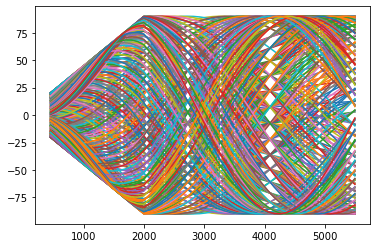

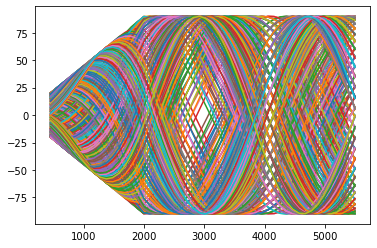

In [21]:
plt.close('all')
# Proposed parametrization 

def f(v, vshift): # vectorized version for plotting 
    out = v/vshift 
    out[v > vshift] = 1
    
    return out 

def profile_plot(Vs, shift, V0):
    return lambda V: np.cos(V*Vs + shift)*90 * f(V, V0)

# A constant parametrization is recovered with Vs = 0 

V = np.linspace(5500, 450)

# plt.figure(figsize=(10,10))
# for Vs in np.linspace(0, 0.005):
#     for bank_max in np.linspace(0, 90, 9):
#         plt.plot(V, profile(Vs,bank_max)(V), 'k', alpha=0.1)
        
        
# Look for two reversal families
# plt.figure(figsize=(10,10))
# V_reduce = 2000  # velocity magnitude at which to begin reducing bank magnitude 
# n1 = 0
# n2 = 0
# for Vs in np.linspace(0, 0.004, 100):
# #     for shift in np.linspace(0, 2*np.pi, 20):
#     for shift in np.linspace(0, 2*np.pi, 20):
#         bank = profile_plot(Vs, shift, V_reduce)(V)

#         zc = len(zcd(bank))

#         if zc == 2:
#             n2 += 1
#             plt.figure(2)
#             plt.plot(V, bank, alpha=1, label="Vs={:.5f}".format(Vs))
            
#         elif zc == 1:
#             n1 += 1
#             plt.figure(3)
#             plt.plot(V, bank, alpha=1, label="Vs={:.5f}".format(Vs))
        
# # plt.legend()
# # plt.figure(3)
# # plt.legend()
# print("{} 1-reversal, {} 2-reversal".format(n1, n2))
# plt.show()

In [ ]:
# To iniatialize, we should determine some approx optimal profiles for one and two reversals based on altitude at a terminal velocity and dr/crossrange 
# We could also solve the true OCP
# Then do nonlinear least squares to fit the parametrization to the solution 

In [ ]:
x0 = InitialState(vehicle='heavy')
print("m0 = {} kg".format(x0[-1]))
Vf = 525 

sim = Simulation(cycle=Cycle(1), output=False, use_da=False, **EntrySim(Vf=Vf), )

def f(v, vshift):
    if v > vshift:
        return 1
    else:
        return v/vshift
    
def profile(Vs, shift, V0):
    return lambda V: np.cos(V*Vs + shift)*np.pi/2 *f(V,V0)

V = np.linspace(x0[3], Vf)
Vr = 2000 

Xf = []
prof = []
for Vs in np.linspace(0.0, 0.005, 5):
    for shift in np.linspace(0, 2*np.pi, 36): 
        
#         bank = profile(Vs, shift)(V)
#         if zcd(bank): # has at least one reversal 
        prof.append((Vs, shift, Vr))
        ref_profile = lambda **d: profile(Vs, shift, Vr)(d['velocity'])
        res = sim.run(x0, [ref_profile])
        Xf.append(sim.x)
#         else:
#             continue
            
Xf = np.array(Xf)
prof = np.array(prof)

In [ ]:
r, th, ph, v, fpa, psi, s, m = Xf.T
h = sim.edlModel.altitude(Xf[:,0], km=True)
# plt.hist(h)

vs,shift,vr = prof.T
shift = np.degrees(shift)
# shift = shift < 180 # use this to create a dichotomy


plt.figure()
plt.subplot(211)
plt.scatter(v, h, c=shift)
plt.colorbar()

plt.subplot(212)
plt.scatter(v, h, c=vs)
plt.xlabel('Velocity (m/s)')
plt.ylabel('Altitude (km)')
plt.colorbar()


plt.figure()
plt.subplot(211)
plt.scatter(th*3396.2, -ph*3396.2, c=shift)
plt.colorbar()

plt.subplot(212)
plt.scatter(th*3396.2, -ph*3396.2, c=vs)
plt.colorbar()
plt.xlabel('DR (km)')
plt.ylabel('CR (km)')

# Plot just the "good" ones 
trim = h > -1
trim = np.logical_and(trim, np.abs(ph)*3396.2 < 1)

plt.figure()
plt.scatter(v[trim], h[trim])
plt.xlabel('Velocity (m/s)')
plt.ylabel('Altitude (km)')

plt.figure()
plt.scatter(th[trim]*3396.2, -ph[trim]*3396.2, c=h[trim])
plt.xlabel('DR (km)')
plt.ylabel('CR (km)')
plt.title('Color = Altitude')
plt.colorbar()

plt.figure()
plt.hist(vs[trim])
plt.show()

In [65]:
import pandas as pd 
data = np.concatenate([Xf, prof], axis=1)
cols = ['radius','longitude','latitude','velocity','fpa','azimuth','rtg','mass', 'scale','shift']
df = pd.DataFrame(data=data, columns=cols)
# df.to_csv("./data/profile30k.csv", index=False)

In [ ]:
# find the best profile so far 

cr = np.abs(ph)*3396.2
keep = cr <= 0.2
i = np.argmax(h[keep])
print("Max altitude at Vf with less than 200 m crossrange = {:.2f}".format(np.max(h[keep])))
opt = prof[keep][i]
print("From profile with Vs = {}, shift = {}".format(*opt))
x_opt = Xf[keep][i]
print(x_opt[1]*3396.2)
plt.plot(V, profile_plot(*opt)(V))
plt.show()

## Vectorized Monte Carlo to allow us to compare parametrizations and other guidance aspects rapidly 

In [66]:
class VMC(object):
    """ Monte carlo class """

    def __init__(self):

        self.samples    = None
        self.control    = None
        self.mc         = None


    def reference_data(self, ref_profile, Vf=470, plot=False):
        """ In closed loop simulations, generate reference data once and use it
            each simulation
        """
        print("Generating reference data...")
        from Simulation import Simulation, Cycle, EntrySim
        from InitialState import InitialState
        # from ParametrizedPlanner import profile
        # from Utils.submatrix import submatrix
        from scipy.interpolate import interp1d

        x0 = InitialState()
        sim = Simulation(cycle=Cycle(0.2), output=False, **EntrySim(Vf=Vf))
        res = sim.run(x0, [ref_profile])
        self.ref_sim = sim

        if plot:
            sim.plot(compare=False)
            plt.show()
        # self.x0_nom = InitialState(1, bank=bank[0])
        print("...done. ")
        print(sim.history.shape)

    def sample(self, N, sample_type='S', parametric=True, initial=False, knowledge=False):
        """ Generates samples for use in Monte Carlo simulations """
        from Uncertainty import getUncertainty
        uncertainty = getUncertainty(parametric=parametric, initial=initial, knowledge=knowledge)

        self.samples = uncertainty['parametric'].sample(N, sample_type)
        self.psamples = uncertainty['parametric'].pdf(self.samples)
        print(" ")
        print("Generating {} samples...".format(N))

        str2name = {'S': 'Sobol', 'R': 'Random', 'L': 'Latin hypercube'}

        print("     {} sampling method".format(str2name[sample_type]))
        print("     Parametric uncertainty only")

    def run(self, x0, save=None):
        import time 
        if self.control is None:
            print(" ")
            print("Warning: The controls must be set prior to running.")
            print("Exiting.")
            return

        if self.samples is None:
            print(" ")
            print("Warning: The number and type of sampling must be set prior to running.")
            print("Exiting.")
            return


        print(" ")
        print("Running Monte Carlo...")
        t_start = time.time()
        self._run(x0)
        print("Monte Carlo complete, time elapsed = {} s.".format(time.time()-t_start))

        if save is None:
            saveDir = './data/'
            filename = getFileName('MC_{}'.format(len(self.samples.T)), saveDir)
            fullfilename = saveDir + filename
            print("Saving {} to default location {}".format(filename, saveDir))
        elif save is False:
            return
        else:
            print("Saving data to user location {}".format(save))
            fullfilename = save

        savemat(fullfilename, {'xf': self.xf, 'states': self.mc, 'samples': self.samples, 'pdf': self.psamples})

    def _run(self, x, stepsize=1):
        
        edl = EDL(self.samples, Energy=True)
        
        self.model = edl
        optSize = self.samples.shape[1]
        if x.ndim == 1:  # Allows a single initial condition or an array
            x = np.tile(x, (optSize, 1)).T
        X = [x]
        energy = np.mean(edl.energy(x[0], x[3], False))
        print("E0 {:.1f}".format(energy))
        energyf = edl.energy(edl.planet.radius, 250, False)  # go down to low energy then parse afterward
        print("Ef {:.1f}".format(energyf))

        U = []
        E = [energy]
        while True:
            # print("E: {:.1f}".format(energy))
            Xc = X[-1]
            energys = edl.energy(Xc[0], Xc[3], False)
#             emax = np.max(energys)
#             emin = np.min(energys)
#             print("Ediff = {}".format(emax-emin))
            lift, drag = edl.aeroforces(Xc[0], Xc[3], Xc[6])

            # Range control
            u = self.control(energys, Xc)
            U.append(u)

            # Shape the control
            u.shape = (1, optSize)
            u = np.vstack((u, np.zeros((2, optSize))))
            de = -np.mean(drag)*np.mean(Xc[3]) * stepsize
            # if (energy + de) < energyf:
            #     de = energyf - energy
            eom = edl.dynamics(u)
            X.append(RK4(eom, X[-1], np.linspace(energy, energy+de, 10))[-1])
            energy += de
            E.append(energy)

            if np.isnan(energy):
                print("Something wrong")
                break

            if energy <= energyf:
                print("energy depleted ")
                break 

            if len(E) > 6000:
                print("Breaking ")
                break
        X = np.array(X)
        U = np.array(U)
        print("MC shape")
        print(X.shape)
        print(U.shape)
        self.mc_full = X
        self.mc_control = U 
        self.trigger()  # This should be moved to a method that the user controls after running the MC
        # This will provide flexibility to use different triggers 

    def set_trigger(self, trigger_function):
        self._trigger = trigger_function 

    def trigger(self):
        xfi = [self._trigger(traj) for traj in np.transpose(self.mc_full, (2,0,1))]
        xf = [traj[i] for i, traj in zip(xfi, np.transpose(self.mc_full, (2,0,1)))], 
        self.xf = np.array(xf).squeeze()
        print("Terminal state shape: ")
        print(np.shape(self.xf))
        self.mc = [traj[:i] for i, traj in zip(xfi, np.transpose(self.mc_full, (2,0,1)))]
        self.mcu = [traj[:i] for i, traj in zip(xfi, np.transpose(self.mc_control, (2,0,1)))]
        
    def plot_trajectories(self, figsize=(10, 6)):
        
        plt.figure(1, figsize=figsize)

        print(np.shape(self.mcu))
        for X,U in zip(self.mc,self.mcu): # each is n_samples x n_points now
            r,lon,lat,v,fpa,psi,m = X.T
            dr = self.model.planet.radius*lon/1000
            cr = -self.model.planet.radius*lat/1000
            h = self.model.altitude(r, km=True)
            plt.figure(1)
            plt.plot(v, h )
            plt.xlabel('Velocity ')

            plt.figure(2, figsize=figsize)
            plt.plot(cr, dr)
            
            plt.figure(3, figsize=figsize)
            plt.plot(v, U)
            plt.xlabel('Velocity ')

    def plot(self, figsize=(10, 6), fontsize=16):
        try:
            self.mc 
            self.xf 
        except AttributeError:
            if hasattr(self, 'mc_full'):
                print("MonteCarlo has been run but trigger has not been called to determine final states.")
            else:
                print("MonteCarlo must be run before plotting.")
            return 



        r,lon,lat,v,fpa,psi,m = self.xf.T
    
        h = (r-self.model.planet.radius)/1000
        dr = self.model.planet.radius*lon/1000
        cr = -self.model.planet.radius*lat/1000
        
        plt.figure(3)
        plt.plot(v, h,'o')
        plt.xlabel('Velocity ')
        plt.ylabel('Altitude ')
        plt.figure(4)
        plt.scatter(cr, dr, c=h)
        plt.xlabel('Crossrange')
        plt.ylabel('Downrange')

        plt.title("Altitude")
        plt.colorbar()
        
#         plt.figure(5)
#         plt.plot(v, np.degrees(self.mcu),'o')
#         plt.xlabel('Velocity ')
#         plt.ylabel('Bank ')

        try:
            xf = self.ref_sim.history[-1]
            hor_err = np.sqrt((lon - xf[1])**2 + xf[2]**2)*3397
            
            plt.figure(5, figsize=figsize)
            plt.hist(hor_err, cumulative=True, histtype='step', bins='auto', linewidth=4, density=True)
            plt.xlabel("Horizontal Error (km)")
        except AttributeError:  # No ref sim, perhaps because loaded from file, or because no reference is needed 
            pass 

        # plt.figure(6, figsize=figsize)
        # plt.hist((r-self.model.planet.radius)/1000., cumulative=True, histtype='step', bins='auto', linewidth=4, density=True)
        # plt.xlabel("Final Altitude (km)")

    def load(self, mat_file):
        data = loadmat(mat_file)
        print(data['states'].shape)
        try:
            self.xf = data['xf']
        except KeyError:
            self.xf = data['states'][-1]

        self.mc = np.transpose(data['states'], (0,2,1))
        self.samples = data['samples']
        self.psamples = data['pdf']
        edl = EDL(self.samples, Energy=True)
        self.model = edl


def getFileName(name, save_dir):
    """
        Looks in 'save_dir' for files with the pattern name-date-number

        I.e. if name = 'MC' and dir/MC-date-1 exists, MC-date-2 will be returned.
    """
    date = datetime.now().date()

    files = os.listdir(save_dir)
    current = 1
    fname = "{}_{}_{}.mat".format(name, date, current)
    while fname in files:
        current += 1
        fname = "{}_{}_{}.mat".format(name, date, current)

    return fname

def velocity_trigger(Vf=550):
    
    def _trigger(traj):
        for idx, state in enumerate(traj):
            if state[3] <= Vf:  
                return idx
        return -1
    return _trigger 

def altitude_trigger(h=4):
    
    def _trigger(traj):
        for idx,state in enumerate(traj):
            if (state[0]-3397000)/1000. <= h:
                return idx
        return -1
    return _trigger
            

In [70]:
# Create a vectorized controller 

def f_vector(v, vshift):
    out = v/vshift 
    out[v > vshift] = 1
    
    return out 

def profile(Vs, shift, V0):
    return lambda E,X: np.cos(X[3]*Vs + shift)*np.pi/2 * f_vector(X[3],V0)

x0 = InitialState(vehicle='heavy', fpa=np.radians(-20.8))
Vf = 500

V = np.linspace(x0[3], Vf)
param = []
for Vs in np.linspace(0.0, 0.005, 100):
# for Vs in [0]:
    for Vr in [ 2500,]:
        for shift in np.linspace(0, 2*np.pi, 371): 
            param.append((Vs, shift, Vr))
        
param = np.array(param)
print(np.shape(param))

(37100, 3)


In [71]:
mc = VMC()
mc.sample(param.shape[0])
mc.samples *= 0

mc.control = profile(*param.T)
mc.set_trigger(velocity_trigger(Vf))
# mc.set_trigger(altitude_trigger(4.6)) # 4.6 km is the optimal altitude at 500 m/s with efpa -20.8. The final velocity is basically a measure of the suboptimality wrt fuel consumption 

mc.run(x0, save=False)

 
Generating 37100 samples...
     Sobol sampling method
     Parametric uncertainty only
 
Running Monte Carlo...
E0 18509313.6
Ef 31250.0
energy depleted 
MC shape
(168, 7, 37100)
(167, 1, 37100)
Terminal state shape: 
(37100, 7)
Monte Carlo complete, time elapsed = 217.21979594230652 s.


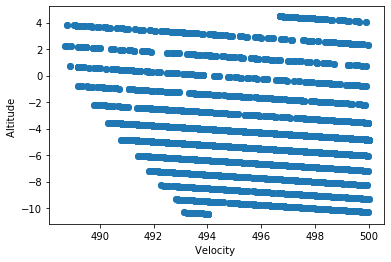

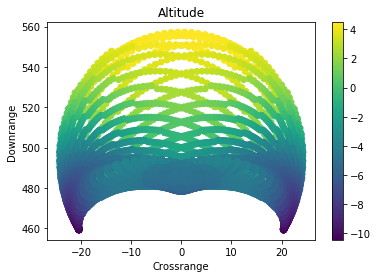

In [72]:
mc.plot()
plt.show()

In [ ]:
mc.plot_trajectories()
plt.show()

Max altitude at Vf = 497.9 m/s with less than 200 m crossrange = 4.31
From profile with Vs = 0.00010101010101010101, shift = 1.222673897613325, Vr = 2500.0
DR = 550.6 km


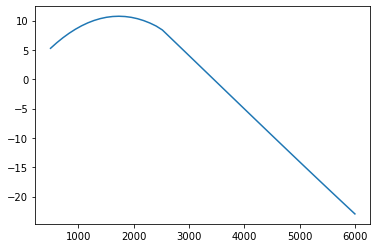

In [77]:
r,lon,lat,v,fpa,psi,m = mc.xf.T

h = (r-mc.model.planet.radius)/1000
dr = mc.model.planet.radius*lon/1000
cr = -mc.model.planet.radius*lat/1000

keep = np.abs(cr) <= 0.2
i = np.argmax(h[keep])
print("Max altitude at Vf = {:.1f} m/s with less than 200 m crossrange = {:.2f}".format(v[keep][i],np.max(h[keep])))
opt = param[keep][i]
print("From profile with Vs = {}, shift = {}, Vr = {}".format(*opt))
print("DR = {:.1f} km".format(dr[keep][i]))
plt.plot(V, profile_plot(*opt)(V))
plt.show()

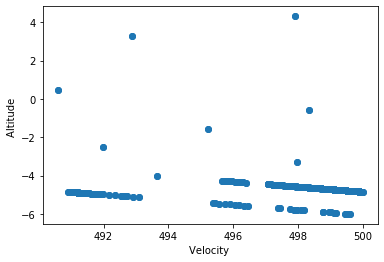

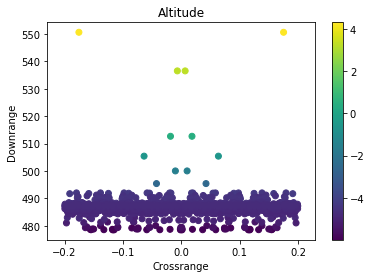

In [78]:
plt.figure(3)
plt.plot(v[keep], h[keep],'o')
plt.xlabel('Velocity ')
plt.ylabel('Altitude ')

plt.figure(4)
plt.scatter(cr[keep], dr[keep], c=h[keep])
plt.xlabel('Crossrange')
plt.ylabel('Downrange')

plt.title("Altitude")
plt.colorbar()
plt.show()